In [12]:
%matplotlib notebook
from tessreduce import *

In [2]:
obj = sn_lookup('SN2018fhw',print_table=False)

getting TPF from TESScut
made reference
made source mask
calculating background
background subtracted
calculating centroids
!!Re-running for difference image!!
shifting images
remade mask
background
Field calibration
Target is below -30 dec, calibrating to SkyMapper photometry.


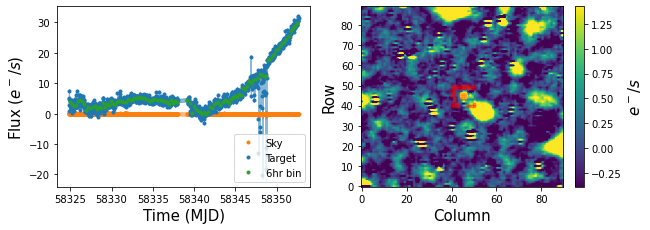

In [4]:
tess = tessreduce(obs_list=obj,reduce=True)

In [5]:
table = Get_Catalogue(tess.tpf,Catalog='skymapper')
table = Skymapper_df(table)

In [6]:
tflux = tess.flux + tess.ref

In [29]:
system = 'skymapper'
ind = (table.imag.values < 19) & (table.imag.values > 14)
tab = table.iloc[ind]
x,y = tess.wcs.all_world2pix(tab.RAJ2000.values,tab.DEJ2000.values,0)
tab['col'] = x
tab['row'] = y

e, dat = Tonry_reduce(tab,system=system)
tess.ebv = e[0]

gr = (dat.gmag - dat.rmag).values
ind = (gr < 1) & (dat.imag.values < 17)
d = dat.iloc[ind]
x,y = tess.wcs.all_world2pix(d.RAJ2000.values,d.DEJ2000.values,0)
d['col'] = x
d['row'] = y
pos_ind = (1 < x) & (x < tess.ref.shape[0]-2) & (1 < y) & (y < tess.ref.shape[0]-2)
d = d.iloc[pos_ind]

    # account for crowding 
for i in range(len(d)):
    x = d.col.values[i]
    y = d.row.values[i]

    dist = np.sqrt((tab.col.values-x)**2 + (tab.row.values-y)**2)

    ind = dist < 1.5
    close = tab.iloc[ind]

    d['gmag'].iloc[i] = -2.5*np.log10(np.nansum(mag2flux(close.gmag.values,25))) + 25
    d['rmag'].iloc[i] = -2.5*np.log10(np.nansum(mag2flux(close.rmag.values,25))) + 25
    d['imag'].iloc[i] = -2.5*np.log10(np.nansum(mag2flux(close.imag.values,25))) + 25
    d['zmag'].iloc[i] = -2.5*np.log10(np.nansum(mag2flux(close.zmag.values,25))) + 25
    if system == 'ps1':
        d['ymag'].iloc[i] = -2.5*np.log10(np.nansum(mag2flux(close.ymag.values,25))) + 25
# convert to tess mags
if system == 'ps1':
    d = PS1_to_TESS_mag(d,ebv=tess.ebv)
else:
    d = SM_to_TESS_mag(d,ebv=tess.ebv)


flux = []
eflux = []
eind = np.zeros(len(d))
for i in range(len(d)):
    mask = np.zeros_like(tess.ref)
    mask[int(d.row.values[i] + .5),int(d.col.values[i] + .5)] = 1
    mask = convolve(mask,np.ones((3,3)))
    flux += [np.nansum(tflux*mask,axis=(1,2))]
    m2 = np.zeros_like(tess.ref)
    m2[int(d.row.values[i] + .5),int(d.col.values[i] + .5)] = 1
    m2 = convolve(m2,np.ones((7,7))) - convolve(m2,np.ones((5,5)))
    eflux += [np.nansum(tflux*m2,axis=(1,2))]
    if np.nansum(tess.ref*m2) > 50:
        eind[i] = 1
eind = eind == 0
flux = np.array(flux)
eflux = np.array(eflux)
#eind = abs(eflux) > 20
flux[~eind] = np.nan

In [16]:
flux.shape

(208, 1267)

In [35]:
eh = np.nanmedian(flux/np.nanmedian(flux,axis=1)[:,np.newaxis],axis=0)

<IPython.core.display.Javascript object>


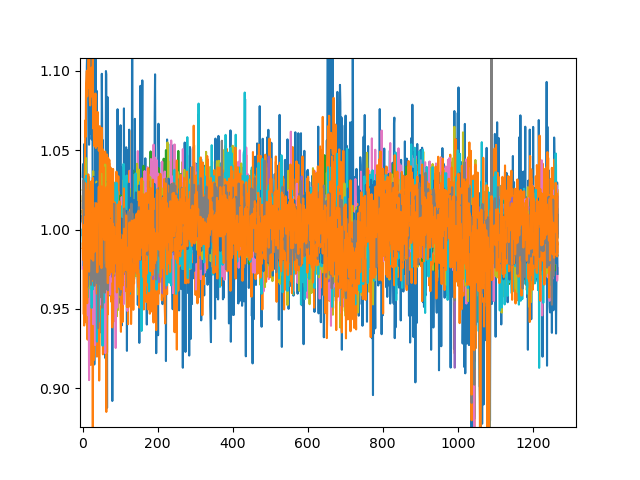

In [34]:
plt.figure()
for i in range(len(flux)):
    plt.plot(flux[i,:]/np.nanmedian(flux[i,:]))

<IPython.core.display.Javascript object>


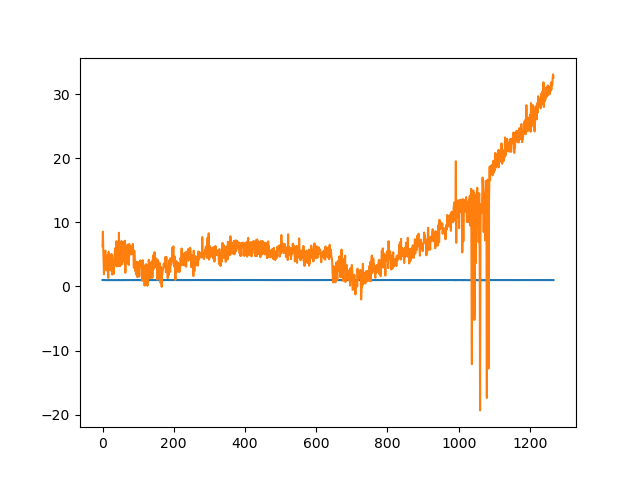

In [39]:
plt.figure()
plt.plot(eh)
plt.plot(tess.lc[1]+eh)